In [60]:
import argparse
import numpy as np
import torch
import json
import pprint
from PIL import Image, ImageDraw
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, RandomGrayscale, ColorJitter
import tempfile
import tqdm
import os
import collections
import sklearn.metrics
from scipy.stats import rankdata
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
#!mkdir /content/images
!wget https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip  # visual genome
# https://s3.us-west-2.amazonaws.com/ai2-rowanz/vcr1images.zip # VCR
!unzip images2.zip -d /content/images

In [5]:
class SquarePad:
    # https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/9
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

In [53]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, data, args, training=False):
        self.args = args
        self.data = data
        self.id2data = {d['instance_id']: d for d in self.data}
        self.training = training
        if self.args.widescreen_processing in [0, 1]:
            self.preprocess = self._transform_train(args.input_resolution) if self.training else self._transform_test(args.input_resolution)
        else:
            self.preprocess = self._transform_train_pad(args.input_resolution) if self.training else self._transform_test_pad(args.input_resolution)

    def url2filepath(self, url):
        if 'VG_100K_2' in url:
            return self.args.vg_dir + '/'.join(url.split('/')[-2:])
        # else:
        #     # http://s3-us-west-2.amazonaws.com/ai2-rowanz/vcr1images/lsmdc_3023_DISTRICT_9/3023_DISTRICT_9_01.21.02.808-01.21.16.722@5.jpg
        #     if 'vcr1images' in self.args.vcr_dir:
        #         return self.args.vcr_dir + '/'.join(url.split('/')[-2:])
        #     else:
        #         return self.args.vcr_dir + '/'.join(url.split('/')[-3:])

    def hide_region(self, image, bboxes):
        image = image.convert('RGBA')
        if self.args.hide_true_bbox == 1: # hide mode
            draw = ImageDraw.Draw(image, 'RGBA')
        if self.args.hide_true_bbox in [2,5,7,8,9]: #highlight mode
            overlay = Image.new('RGBA', image.size, '#00000000')
            draw = ImageDraw.Draw(overlay, 'RGBA')
        if self.args.hide_true_bbox == 3 or self.args.hide_true_bbox == 6: #blackout mode or position only mode
            overlay = Image.new('RGBA', image.size, '#7B7575ff')
            draw = ImageDraw.Draw(overlay, 'RGBA')
        for bbox in bboxes:
            x = bbox['left']
            y = bbox['top']
            if self.args.hide_true_bbox == 1: # hide mode
                draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])], fill='#7B7575')
            elif self.args.hide_true_bbox in [2,5,7,8,9]: # highlight mode
                draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                               fill='#ff05cd3c', outline='#05ff37ff', width=3)
            elif self.args.hide_true_bbox == 3: # blackout mode
                draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                               fill='#00000000')
            elif self.args.hide_true_bbox == 6: # position only mode
                draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                               fill='#ff05cdff')

        if self.args.hide_true_bbox in [2, 3, 5, 6, 7, 8, 9]:
            image = Image.alpha_composite(image, overlay)

        return image

    def _transform_train(self, n_px):
        return Compose([
            Resize(n_px, interpolation=Image.BICUBIC),
            RandomCrop(n_px),
            RandomHorizontalFlip(),
            #RandomGrayscale(), # these were used in the model in the paper, but, something seems bugged when pytorch updated.
            ColorJitter(brightness=.5, hue=.3),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def _transform_test(self, n_px):
        return Compose([
            Resize(n_px, interpolation=Image.BICUBIC),
            CenterCrop(n_px),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def _transform_train_pad(self, n_px):
        return Compose([
            SquarePad(),
            Resize(n_px, interpolation=Image.BICUBIC),
            RandomHorizontalFlip(),
            #RandomGrayscale(), # these were used in the model in the paper, but, something seems bugged when pytorch updated.
            ColorJitter(brightness=.5, hue=.3),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def _transform_test_pad(self, n_px):
        return Compose([
            SquarePad(),
            Resize(n_px, interpolation=Image.BICUBIC),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def image_to_torch_tensor(self, image):
        if self.args.widescreen_processing == 1:
            width, height = image.size
            if width >= height:
                im1 = {'height': height, 'width': height, 'left': 0, 'top': 0}
                im2 = {'height': height, 'width': height, 'left': width-height, 'top': 0}
            else:
                im1 = {'height': width, 'width': width, 'left': 0, 'top': 0}
                im2 = {'height': width, 'width': width, 'left': 0, 'top': height-width}
            regions = [image.crop((bbox['left'], bbox['top'], bbox['left'] + bbox['width'], bbox['top'] + bbox['height'])) for bbox in [im1, im2]]
            image = torch.stack([self.preprocess(r) for r in regions], 0)
        else:
            image = self.preprocess(image)
        return image

    def __getitem__(self, idx):
        c_data = self.data[idx]

        image = Image.open(self.url2filepath(c_data['inputs']['image']['url']))

        if self.args.hide_true_bbox > 0:
            image = self.hide_region(image, c_data['inputs']['bboxes'])

        clue = c_data['inputs']['clue']
        caption = c_data['targets']['inference']

        cid = c_data['instance_id']
        image = self.image_to_torch_tensor(image)
        return {'image':image, 'caption':caption, 'clue': clue, 'id': cid}

    def get(self, cid):
        return self.id2data[cid]

    def __len__(self):
        return len(self.data)



In [54]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [62]:
class Args:
  def __init__(self):
    self.batch_size= 64 # Increase this if your GPU can handle it
    self.lr = 0.00001
    self.n_epochs= 10
    self.widescreen_processing= 2
    self.hide_true_bbox= 2
    self.vg_dir= 'images/'
    self.input_resolution=(224,224)
    self.workers_dataloader=4

args = Args()

In [63]:
new_train=[]

with open("sherlock_train_v1_1.json") as f:
    train = json.load(f)
    for data in train:
      if "VG_100K_2" in data['inputs']['image']['url']:
        new_train.append(data)

In [64]:
train_loader = torch.utils.data.DataLoader(
        CLIPDataset(new_train, args, training=True),
        batch_size=args.batch_size, num_workers=args.workers_dataloader, shuffle=True, worker_init_fn=worker_init_fn)

In [65]:
len(train_loader)

1596

torch.Size([64, 3, 224, 224])
['they wanted to control what was put on the sandwich.', 'it is a train', 'people use it to tell what time it is', 'this photo was taken during the early Spring', 'This is located in Romania.', 'it might have rained', 'the man is taking a photograph', 'the dog is waiting for its master', "It's a bright and sunny day out.", 'the child is playing in the park', 'it is morning.', 'the owner values formality', 'there is a second story here', 'this is a walk-in cooler', 'The people who own this property love various art expressions.', 'it is summertime', 'This is a commercial airplane.', 'this is a city', 'The sun is setting in the foreground.', 'it is not winter.', 'there is a boat pulling him', 'they are out on a mission to fish', 'This is a living room.', 'it may precipitate', 'The Lion King is currently playing at a local theater.', 'this man is jumping in the air', 'these horses are being kept warm.', 'they are hungry.', 'it is winter', 'It is in a VFW in t

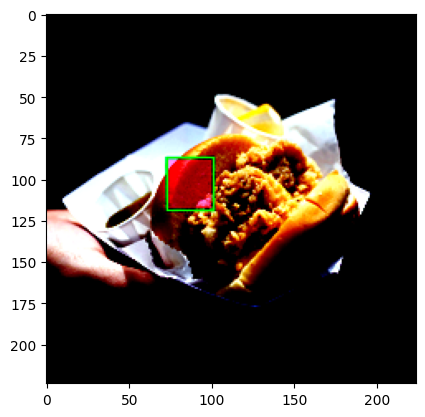

In [67]:
for data in train_loader:
    img = data['image']
    inference = data['caption']
    clue = data['clue']
    plt.imshow(img[0].permute(1, 2, 0))
    print(img.shape)
    print(inference)
    print(clue)
    break

In [49]:
print(len(new_train))

102086


In [35]:
print(len(train))

317054
